# Imports

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt

import pickle
from multiprocessing import Pool

import modeling
import helpers
import plotting
import scienceplots
plt.style.use(['science','no-latex'])
# plt.style.use(['science','ieee','no-latex'])

# Load data

In [2]:
with open('data.pkl', 'rb') as file:
    data_dict = pickle.load(file)
    all_data = data_dict['data']
    meta_data = data_dict['meta_data']

best_params_all_backward = np.load('fitting_results/backward_params.npy')
best_params_all_backward_no_meta = np.load('fitting_results/backward_no_meta_params.npy')

# Parameter recovery

## V1-V1, Cluster 0, backward meta-learning model

In [5]:
this_model = 'option_model'
structure = 'backward'
meta_learning = True
cluster = 0
experiment = 'V1-V1'
fitted_params = best_params_all_backward[(meta_data['Cluster']==cluster) & (meta_data['Condition']==experiment)]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [-2, 1]
epsilon_bounds = [1e-6, 0.99]
bounds = [alpha_bounds, concentration_bounds, epsilon_bounds, epsilon_bounds] 
param_names = ["alpha_2", 'concentration_2', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        alpha_2, concentration_2, epsilon, prior = fitted_params[i]
        sim_data = modeling.option_model(1, 1, alpha_2, 5, 0.2, concentration_2, epsilon, prior, experiment, structure, meta_learning=True)
        all_sim_data = helpers.concatenate_data(sim_data, all_sim_data)
        D = helpers.get_model_fit_data(sim_data, num_block=12)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_{experiment}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_{experiment}_cluster{cluster}_llh.npy', best_llh_all)


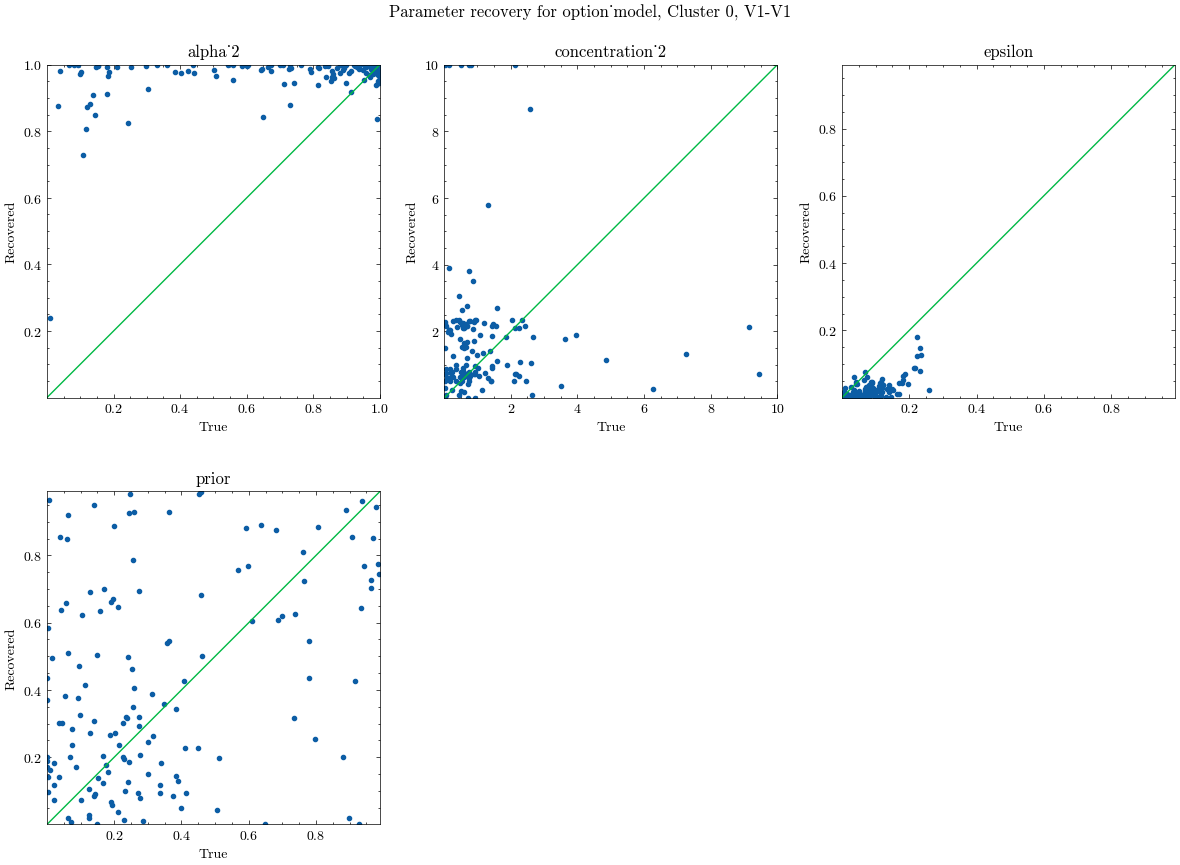

In [6]:
plt.figure(figsize=(12,9))
for p in range(len(bounds)):
    ax = plt.subplot(2, 3, p+1)
    
    this_bounds = bounds[p]
    if 'concentration' in param_names[p]:
        this_bounds[0] = 10**this_bounds[0]
        this_bounds[1] = 10**this_bounds[1]
        plt.plot(10**fitted_params[:,p], 10**best_params_all[:,p], '.')
    else:
        plt.plot(fitted_params[:,p], best_params_all[:,p], '.')
    plt.plot([this_bounds[0],this_bounds[1]], [this_bounds[0], this_bounds[1]])
    plt.xlim(this_bounds)
    plt.ylim(this_bounds)
    plt.xlabel('True')
    plt.ylabel('Recovered')
    plt.title(param_names[p])
    ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {experiment}')
plt.tight_layout()
plt.show()

## Blocks 1-6, Cluster 0, backward no meta-learning model

In [23]:
this_model = 'option_model'
structure = 'backward'
meta_learning = False
cluster = 0
condition = 'All'
fitted_params = best_params_all_backward_no_meta[(meta_data['Cluster']==cluster)]
num_subject = fitted_params.shape[0]

alpha_bounds = [1e-6, 1]
beta_bounds = [1e-6, 10]
concentration_bounds = [-2, 1]
epsilon_bounds = [1e-6, 0.99]
bounds = [alpha_bounds, concentration_bounds, epsilon_bounds, epsilon_bounds] 
param_names = ["alpha_2", 'concentration_2', 'epsilon', 'prior']

best_llh_all = np.zeros(num_subject)
best_params_all = np.zeros((num_subject, len(param_names)))

all_sim_data = {}

if __name__ == "__main__":
    inputs = []
       
    for i in range(num_subject):
        alpha_2, concentration_2, epsilon, prior = fitted_params[i]
        D = helpers.get_model_fit_data(sim_data, num_block=6)  
        inputs.append((this_model, i, 1, alpha_2, concentration_2, epsilon, prior, condition, structure, meta_learning))
        
        
    with Pool() as p:
        results = p.map(modeling.parallel_simulator, inputs)
        
    inputs = []
        
    for i, this_data in results:
        all_sim_data = helpers.concatenate_data(this_data, all_sim_data)
        D = helpers.get_model_fit_data(this_data, num_block=6)  
        inputs.append((this_model, D, structure, i, bounds, meta_learning))

    with Pool() as p:
        results = p.map(modeling.parallel_worker, inputs)

    for i, best_params, best_llh in results:
        best_params_all[i, :], best_llh_all[i] = best_params, best_llh

np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_params.npy', best_params_all)
np.save(f'fitting_results/paramrec_{structure}_no_meta_{condition}_cluster{cluster}_llh.npy', best_llh_all)


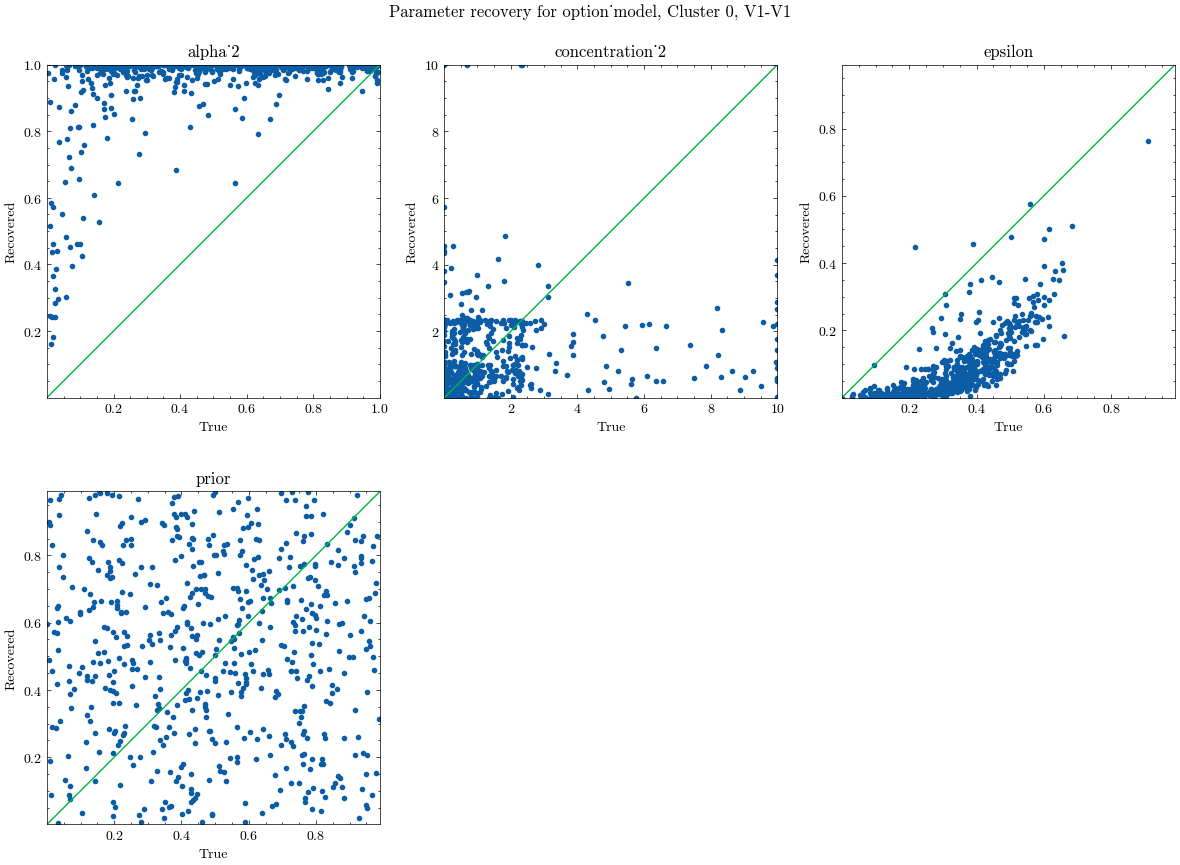

In [24]:
plt.figure(figsize=(12,9))
for p in range(len(bounds)):
    ax = plt.subplot(2, 3, p+1)
    
    this_bounds = bounds[p]
    if 'concentration' in param_names[p]:
        this_bounds[0] = 10**this_bounds[0]
        this_bounds[1] = 10**this_bounds[1]
        plt.plot(10**fitted_params[:,p], 10**best_params_all[:,p], '.')
    else:
        plt.plot(fitted_params[:,p], best_params_all[:,p], '.')
    plt.plot([this_bounds[0],this_bounds[1]], [this_bounds[0], this_bounds[1]])
    plt.xlim(this_bounds)
    plt.ylim(this_bounds)
    plt.xlabel('True')
    plt.ylabel('Recovered')
    plt.title(param_names[p])
    ax.set_box_aspect(1)

plt.suptitle(f'Parameter recovery for {this_model}, Cluster {cluster}, {experiment}')
plt.tight_layout()
plt.show()